In [1]:
from functools import reduce
from os.path import join
from math import log
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from upsetplot import from_contents, UpSet

## How to use this notebook

**Input**: Classification table(s) `tool_rank.csv` generated by the short-read taxonomy module.

**Output**: Various graphs of alpha and beta diversity statistics. Summaries of the number of taxa, summed distance metrics, and shared taxon names are generated as part of the process and thus scattered throughout the notebook. 

1) Grouped bar graph of the **numbers of taxa** found in each sample by each classifier at each target taxonomic rank. 

2) Grouped bar graph of the **Shannon entropy** in each sample by each classifier at each target taxonomic rank. The difference between this metric and the previous one is that the presence of each taxon is weighted by its relative abundance (as estimated by the classifier!) in the sample.

3) Histograms of the Shannon entropy found in each sample by each classifier at the rank of phylum. This can be customized for any desired rank. 

4) Set of i) **Bray-Curtis dissimilarity** and ii) **Jaccard distance** heatmaps between each classifier-sample combination (see relevant section for explanation). 

- Note: These are not automatically saved as that would generate many junk figures. It's easiest to go through them from within the notebook and right-click to save the ones that contain meaningful results!

5) Upset plot of **shared taxa** between classifier-sample combination.

- Note: This is not automatically saved either! 

### Steps

**Usage**: There is 1 cell (indicated by the text `Customize here`) that requires user customization, described below. I designed this notebook specifically for the Microbiome-in-a-Bottle dataset but tried to generalize as much as possible.

1) Add your work directory, target taxonomic ranks, classification tools used, and sample names to the first cell. 

2) Customize the target rank for the Shannon entropy histograms using `rank_index`. The default is phylum.  

In [2]:
# Set seaborn plotting aesthetics as default
sns.set()

In [ ]:
# Customize here
# Add the work directory where all of the standardized classification tool CSVs are
work_dir = '/path/to/'

# Add the taxonomic ranks you want to analyze to the list 
rank_lst = [] # ['species', 'genus', 'family', 'order', 'class', 'phylum']
rank_index = rank_lst.index('phylum') # Replace phylum with any target rank

# Add the classification tools you used to the lists. I like to organize them alphabetically, 
# and organize colours by intensity 
tool_lst = [] # ['metaphlan', 'kraken_bracken', 'xtree']
tools_ordered = [] # ['kraken_bracken', 'metaphlan', 'xtree']
tools_named = [] # ['Kraken2-Bracken', 'MetaPhlan4', 'XTree']
tools_colours = [] # ['#ffa600', '#dd5182', '#003f5c']

# Add your sample names to lists
samples_ordered = [] # ['99_phse', '99_zykt', '99_zytp']
samples_named = [] # ['Phase', 'Zymo Kit', 'Zymo\nThree-Peaks']

# Do not change this! These are 'basic' fields in the standardized report
basic_colnames = ['classifier', 'clade', 'tax_id']

In [4]:
# Merge the standardized classification tool CSVs and check their contents
rank_df_lst = []
for r in rank_lst:
    df_lst = [pd.read_csv(join(work_dir, t + '_' + r + '.csv'), header = 0) for t in tool_lst]
    merged_df = pd.concat(df_lst)
    print('{} {}'.format(r, merged_df.shape))
    rank_df_lst.append(merged_df)

rank_df_lst[0].iloc[[1,20,80],:]

species (8718, 6)
genus (2598, 6)
family (724, 6)
order (358, 6)
class (191, 6)
phylum (106, 6)


,classifier,clade,tax_id,99_phse,99_zykt,99_zytp
1,metaphlan,Acidaminococcaceae unclassified SGB5785,NaN,0.001374,0.000034,0.033326
20,metaphlan,Bacilli bacterium,1903720.0,0.000120,0.001571,0.008458
80,metaphlan,Clostridium sp AM33 3,2292304.0,0.000055,0.002098,0.000335


# Short-Read Classification Dataviz

## Alpha Diversity: Within-sample species richness

### Prepare taxon presence-absence tables

In [5]:
# Make a presence-absence dataframe by casting non-zero relative abundances up to 1
pres_abs_df_lst = []
for r in rank_df_lst:
    tmp_df = r.copy()
    for s in samples_ordered:
        tmp_df[s] = [1 if a > 0 else 0 for a in tmp_df[s]]
    pres_abs_df_lst.append(tmp_df)

pres_abs_df_lst[0].iloc[[1,20,80],:]

,classifier,clade,tax_id,99_phse,99_zykt,99_zytp
1,metaphlan,Acidaminococcaceae unclassified SGB5785,NaN,1,1,1
20,metaphlan,Bacilli bacterium,1903720.0,1,1,1
80,metaphlan,Clostridium sp AM33 3,2292304.0,1,1,1


In [6]:
# Sum the presence-absences of all taxa for each classifier-sample combination
# The result is the number of taxa found in each sample by each classifier
agg_dct = {}
for c in basic_colnames:
    agg_dct[c] = 'first'
for c in samples_ordered:
    agg_dct[c] = 'sum'

agg_rank_df_lst = []
for r in pres_abs_df_lst:
    tmp = r.groupby(r['classifier']).aggregate(agg_dct)
    tmp.drop(columns = basic_colnames, inplace = True)
    tmp.reset_index(inplace = True)
    agg_rank_df_lst.append(tmp)

agg_rank_df_lst[0]

,classifier,99_phse,99_zykt,99_zytp
0,kraken_bracken,2573,3289,4783
1,metaphlan,259,261,278
2,xtree,1366,1838,2290


In [7]:
# Melt the sample columns together for a flatter dataframe
melt_rank_df_lst = []
for r in agg_rank_df_lst:
    tmp = r.melt( id_vars = ['classifier'], 
            value_vars = samples_ordered,
            var_name = 'sample', value_name = 'pres_abs' )
    melt_rank_df_lst.append(tmp)

melt_rank_df_lst[0]

,classifier,sample,pres_abs
0,kraken_bracken,99_phse,2573
1,metaphlan,99_phse,259
2,xtree,99_phse,1366
3,kraken_bracken,99_zykt,3289
4,metaphlan,99_zykt,261
5,xtree,99_zykt,1838
6,kraken_bracken,99_zytp,4783
7,metaphlan,99_zytp,278
8,xtree,99_zytp,2290


### Numbers of taxa per classifier-sample combination

In [8]:
%%capture
# To suppress figure output
# Define plotting region (2 rows, num_samples columns)
num_rows = 2
num_cols = int(len(rank_lst) / num_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,12)) # in.

In [9]:
def grouped_bar_plot(df, r, a, param):
    # p = pres_abs or shannon
    p = sns.barplot(data = df, x = 'sample', y = param, hue = 'classifier', \
                    order = samples_ordered, palette = tools_colours, ax = a)
    p.set_xticklabels(samples_named, size = 12) #, rotation = 45, ha = 'right') # Relabel each of the groups
    p.set(xlabel = r.capitalize(), ylabel = None) # Turns off y-axis label for each subplot, but labels the x-axis the rank
    p.get_legend().remove()
    return p

In [10]:
# Plot the number of taxa identified by each combination of classification tool and sample
for i, df in enumerate(melt_rank_df_lst):
    row = int(i // num_cols)
    col = int(i % num_cols)
    grouped_bar_plot(df, rank_lst[i], axs[row,col], 'pres_abs')
    axs[row,0].set_ylabel('Num. Clades', size = 16)

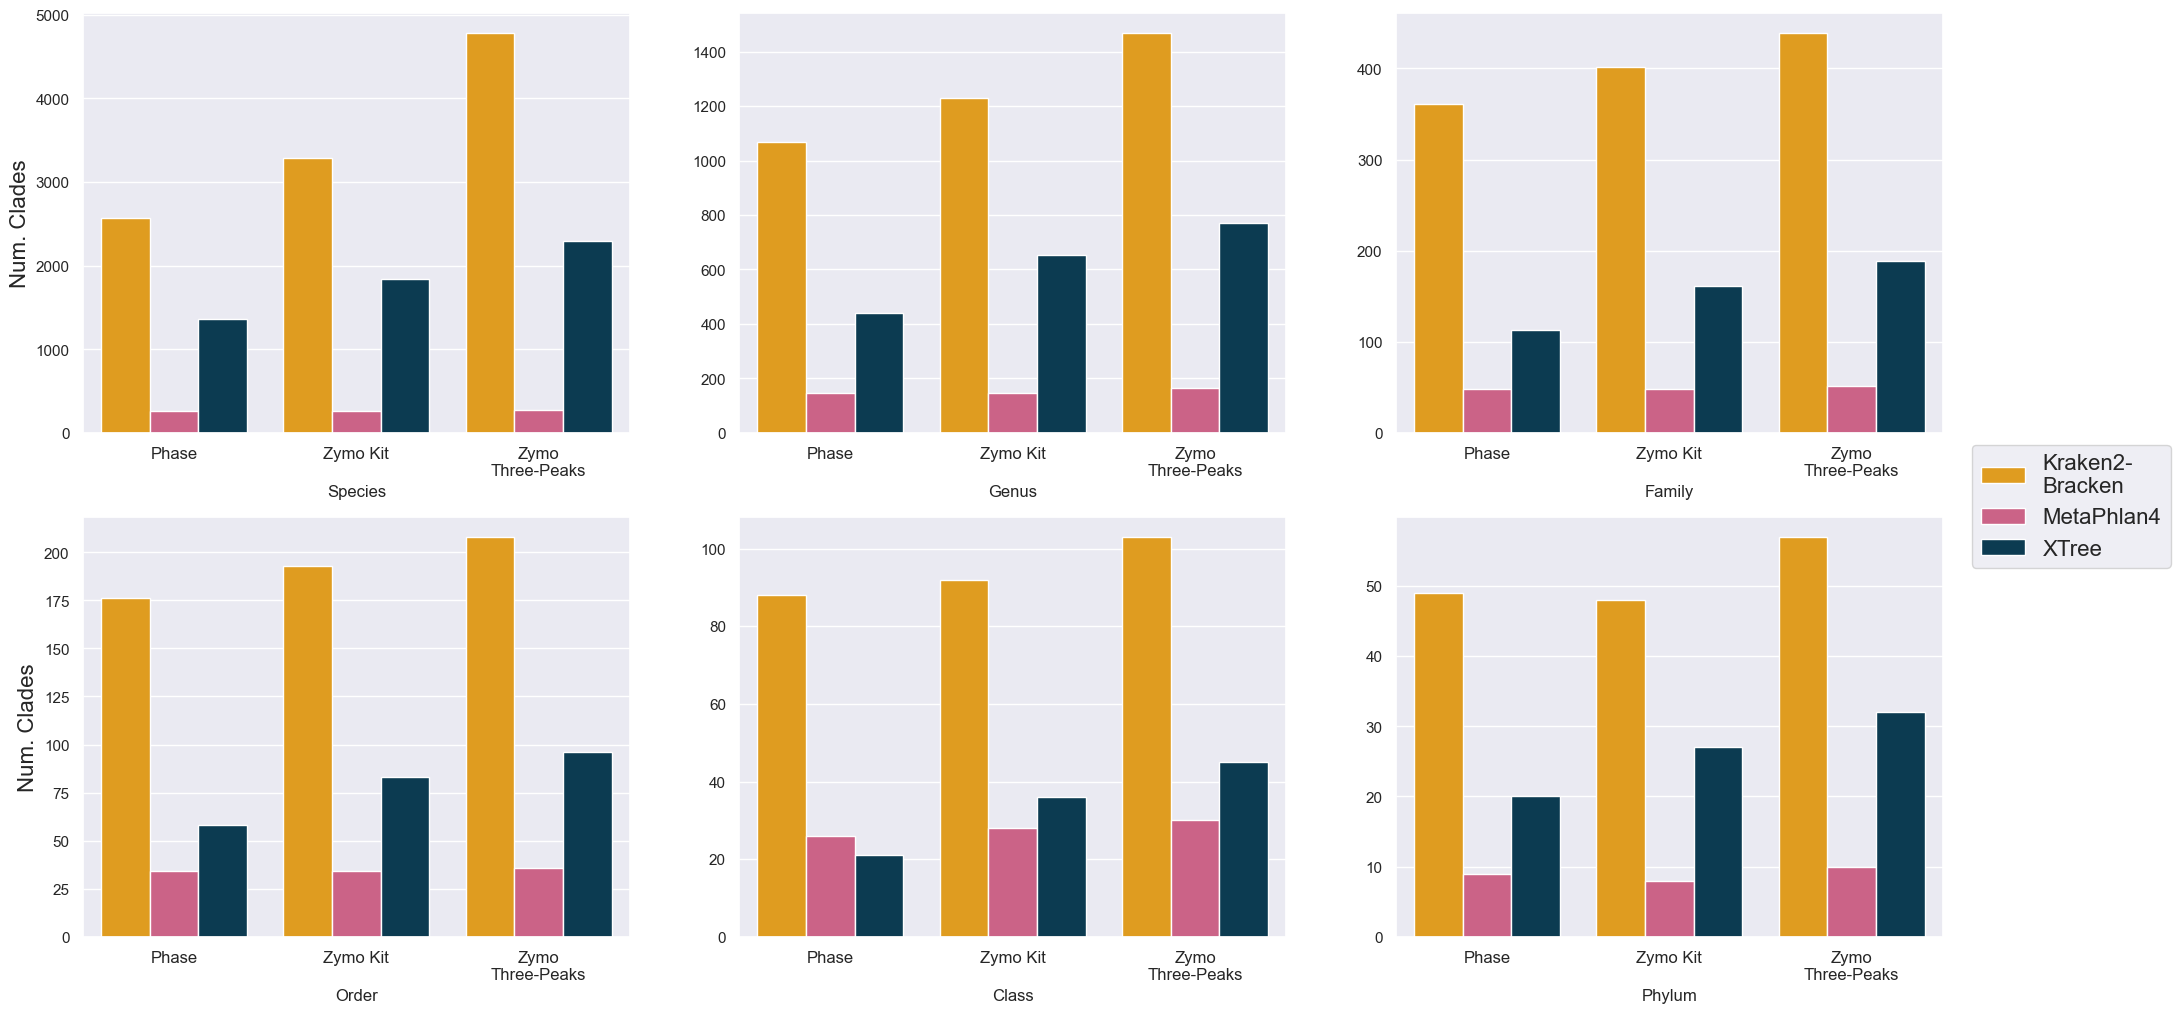

In [11]:
# Add a global legend and plot the graph
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, tools_named, loc = 'center right', fontsize = 16)
fig

In [12]:
# Save a large SVG without padding
fig.savefig(work_dir + '/rank_tool_sample_num_taxa.svg', dpi = 1000, bbox_inches = 'tight')

### Shannon entropy per classifier-sample combination

The Shannon Index is an estimator for both species richness and evenness (i.e.: diversity), but with weight on the richness. The idea behind this metric is that the more species you observe, and the more even their abundances are, the higher the entropy, or the higher the uncertainty of predicting which species you would see next if you were to look at another read from this sample.
Source: https://docs.onecodex.com/en/articles/4136553-alpha-diversity 

In [13]:
def shannon_index(row):
    s_lst = []
    for s in range(len(samples_ordered)):
        if row[3 + s] == 0:
            s_lst.append(0)
        else:
            s_lst.append(-log(row[3 + s])*row[3 + s])
    return list(row[0:3]) + s_lst

In [14]:
# Calculate H for each classifier-sample combination
h_rel_abund_lst = []
for i,r in enumerate(rank_df_lst):
    tmp_lst = list(r.apply(lambda row : shannon_index(row), axis = 1))
    tmp_df = pd.DataFrame(tmp_lst, columns = basic_colnames + samples_ordered)
    print('{} {}'.format(rank_lst[i], tmp_df.shape))
    h_rel_abund_lst.append(tmp_df)

h_rel_abund_lst[0].iloc[[1,20,80],:]

species (8718, 6)
genus (2598, 6)
family (724, 6)
order (358, 6)
class (191, 6)
phylum (106, 6)


,classifier,clade,tax_id,99_phse,99_zykt,99_zytp
1,metaphlan,Acidaminococcaceae unclassified SGB5785,NaN,0.009056,0.000346,0.113356
20,metaphlan,Bacilli bacterium,1903720.0,0.001085,0.010144,0.040366
80,metaphlan,Clostridium sp AM33 3,2292304.0,0.000539,0.012940,0.002682


In [15]:
# Sum H for each classifier-sample combination
agg_dct = {}
for c in basic_colnames:
    agg_dct[c] = 'first'
for c in samples_ordered:
    agg_dct[c] = 'sum'

shan_rank_df_lst = []
for i, r in enumerate(h_rel_abund_lst):
    tmp_df = r.groupby(r['classifier']).aggregate(agg_dct)
    tmp_df.drop(columns = basic_colnames, inplace = True)
    tmp_df.reset_index(inplace = True)
    shan_rank_df_lst.append(tmp_df)
    print('{} {}'.format(rank_lst[i], tmp_df.shape))

shan_rank_df_lst[0]

species (3, 4)
genus (3, 4)
family (3, 4)
order (3, 4)
class (3, 4)
phylum (3, 4)


,classifier,99_phse,99_zykt,99_zytp
0,kraken_bracken,4.122799,3.891315,5.049203
1,metaphlan,3.273946,6.945069,6.712761
2,xtree,4.016539,5.227824,5.394728


In [16]:
# Melt the sample columns together for a flatter dataframe
melt_shan_df_lst = []
for r in shan_rank_df_lst:
    tmp = r.melt( id_vars = ['classifier'], 
            value_vars = samples_ordered,
            var_name = 'sample', value_name = 'shannon' )
    melt_shan_df_lst.append(tmp)

melt_shan_df_lst[0]

,classifier,sample,shannon
0,kraken_bracken,99_phse,4.122799
1,metaphlan,99_phse,3.273946
2,xtree,99_phse,4.016539
3,kraken_bracken,99_zykt,3.891315
4,metaphlan,99_zykt,6.945069
5,xtree,99_zykt,5.227824
6,kraken_bracken,99_zytp,5.049203
7,metaphlan,99_zytp,6.712761
8,xtree,99_zytp,5.394728


In [17]:
%%capture
# To suppress figure output
# Define plotting region (2 rows, num_samples columns)
num_rows = 2
num_cols = int(len(rank_lst) / num_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,12)) # in.

In [18]:
# Plot the number of taxa identified by each combination of classification tool and sample
for i, df in enumerate(melt_shan_df_lst):
    row = int(i // num_cols)
    col = int(i % num_cols)
    grouped_bar_plot(df, rank_lst[i], axs[row,col], 'shannon')
    axs[row,0].set_ylabel('Shannon Index (H)', size = 16)

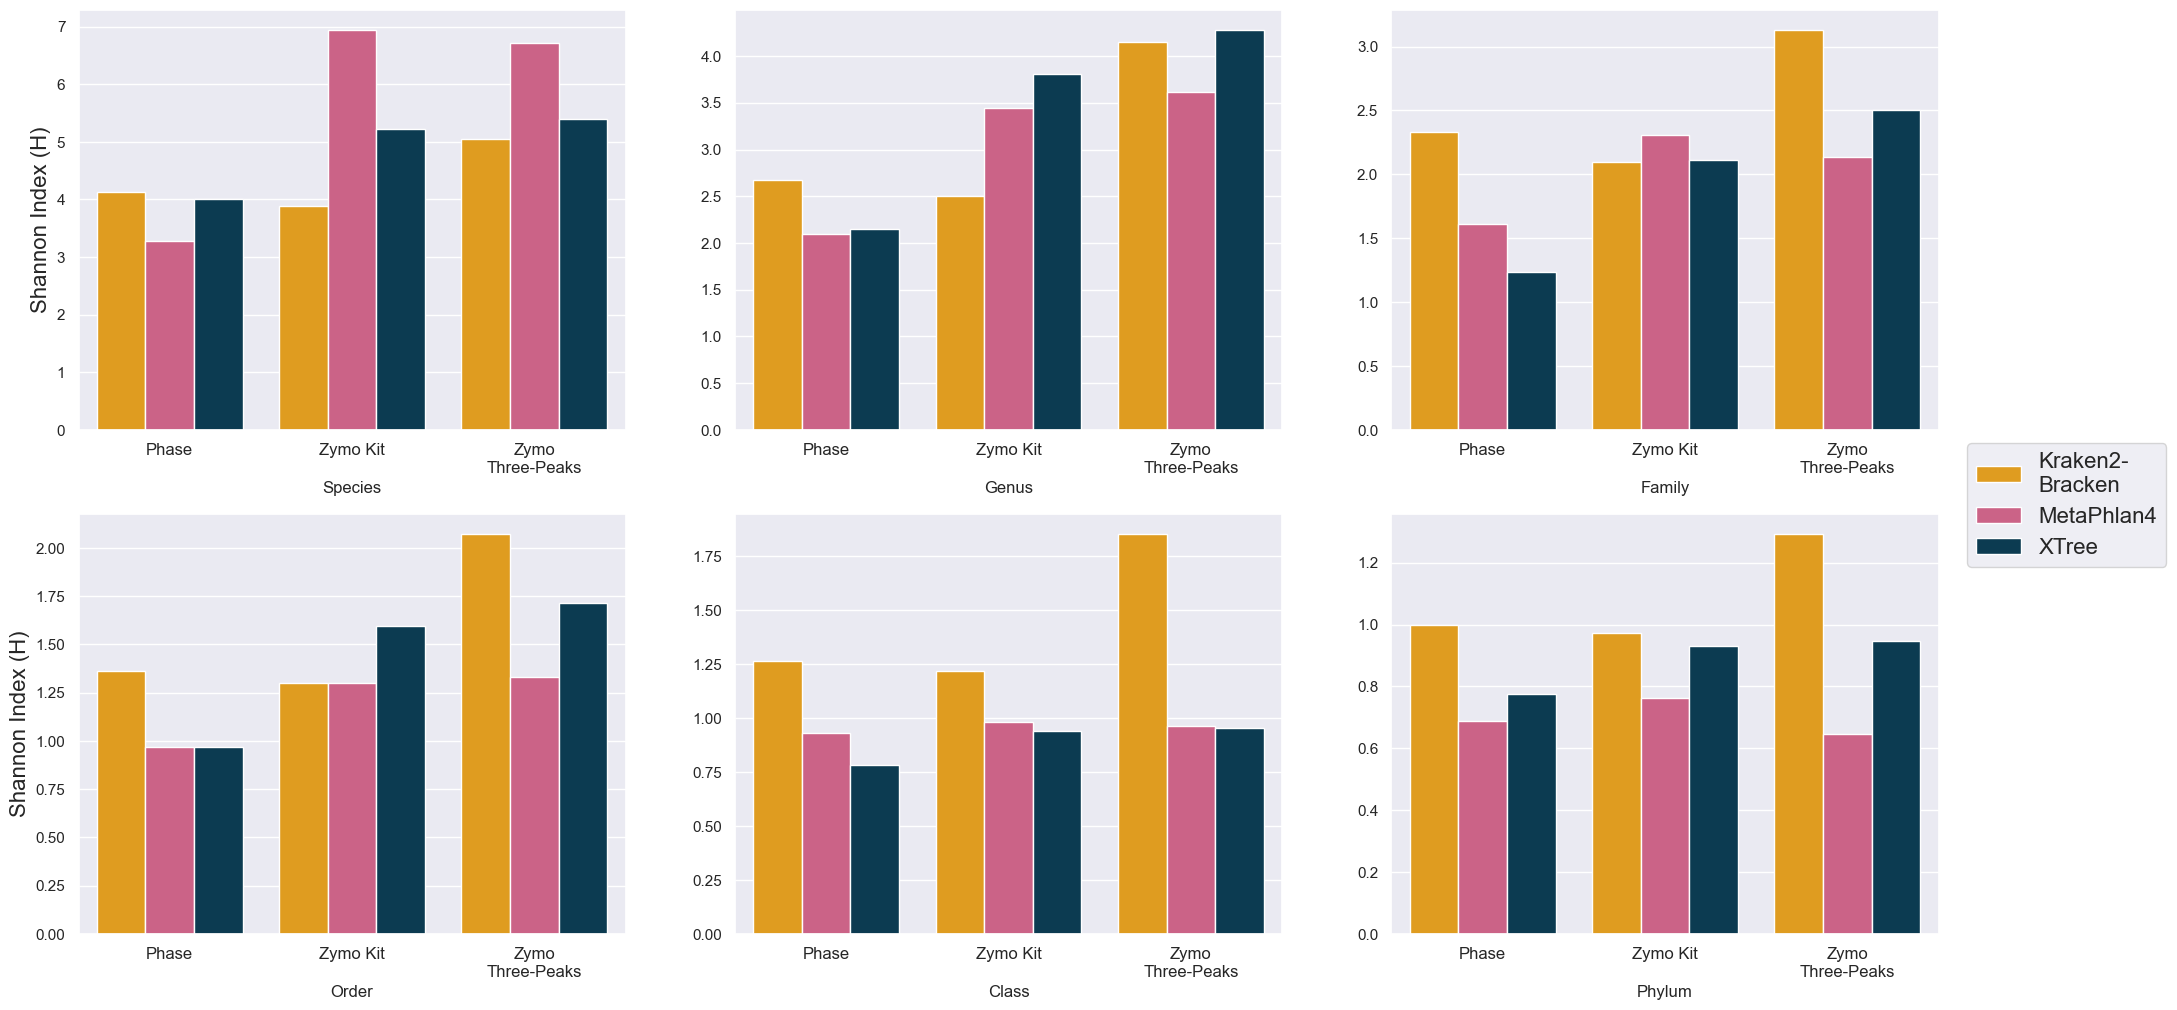

In [19]:
# Add a global legend and plot the graph
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, tools_named, loc = 'center right', fontsize = 16)
fig

In [20]:
# Save a large SVG without padding
fig.savefig(work_dir + '/rank_tool_sample_shan_h.svg', dpi = 1000, bbox_inches = 'tight')

#### Shannon entropy histograms for each classifier-sample combination at the phylum rank

In [21]:
%%capture
# To suppress figure output
# Define plotting region (num_tools rows, num_samples columns)
num_rows = len(tools_ordered)
num_cols = len(samples_ordered)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,16)) # in.

In [22]:
def hist_plot(lst, x_label, c, a):
    p = sns.histplot(data = lst, color = c, ax = a, bins = 12)
    p.set_xlim(0.0,0.4)
    p.set(xlabel = x_label, ylabel = None) # Turns off y-axis label for each subplot, but labels the x-axis the rank
    return p

In [23]:
# Plot the phylum Shannon indices for each classifier-sample combination
phylum_h_df = h_rel_abund_lst[rank_index]
for i, t in enumerate(tools_ordered): # 0,1,2 % 3
    row = int(i % num_cols)
    sub_df = phylum_h_df[phylum_h_df['classifier'] == t]
    for j, s in enumerate(samples_ordered):
        col = int(j % num_cols)
        sub_lst = list(sub_df[s])
        hist_plot(sub_lst, samples_named[j], tools_colours[i], axs[row,col])
    axs[row,0].set_ylabel(tools_named[i], size = 16)

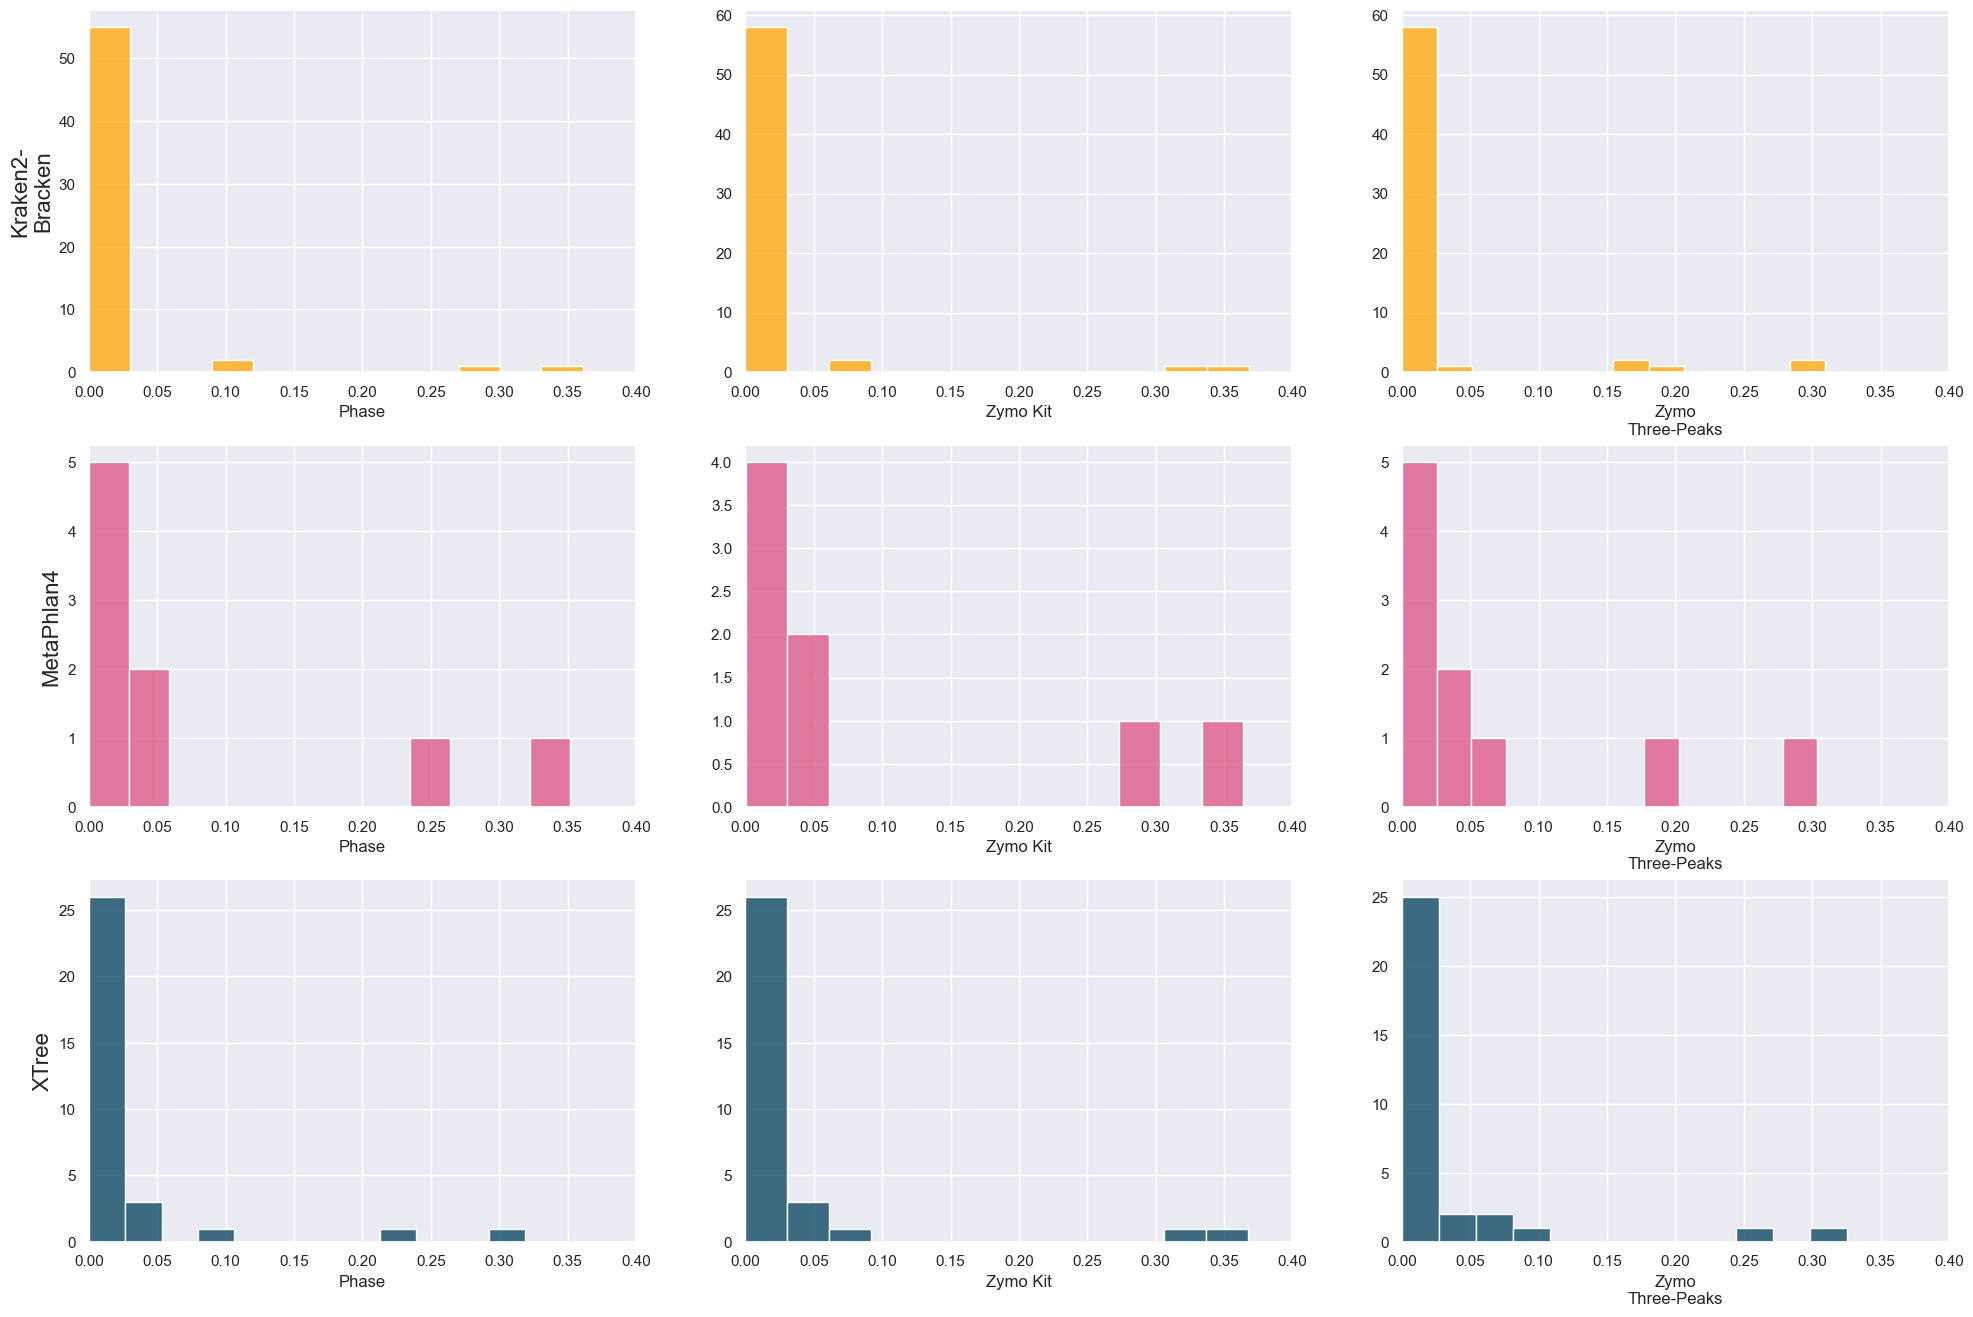

In [24]:
fig

In [25]:
# Save a large SVG without padding
fig.savefig(work_dir + '/phylum_tool_sample_shan_hist.svg', dpi = 1000, bbox_inches = 'tight')

## Beta Diversity: Between-sample species diversity

Beta diversity is a term used to express the differences between samples or environments. Bray-Curtis dissimilarity examines the abundances of microbes that are shared between two samples, and the number of microbes found in each. Bray-Curtis dissimilarity ranges from 0 to 1. Like Bray-Curtis dissimilarity, the Jaccard distance is also bounded between 0 and 1. Also like Bray-Curtis dissimilarity, it should be considered a "dissimilarity" as opposed to a true "distance". However Jaccard distance does not take abundances into account; just the presence of microbes in one or both samples.

Source: https://docs.onecodex.com/en/articles/4150649-beta-diversity

### Preparing classifier-sample dataframes

In [26]:
# Convert the raw relative abundance dataframes into classifier-sample relative abundance 
# dataframes by merging the sample and classifier columns so that each combination has its
# own column. Here, I have 3 samples (technical replicates of the same microbiome) and 3
# classifiers so there are 9 combinations in total. 
rank_bcd_nona_lst = []
rank_bcd_zero_lst = []
rank_jcd_lst = []
cmb_ra_lst = []
for i,r in enumerate(rank_df_lst):
    ra_df = r.copy()
    cmb_lst = []
    for j,t in enumerate(tools_ordered):
        sub_df = ra_df[ra_df['classifier'] == t].copy()
        sub_df.columns = ['tmp', 'clade', 'tax_id'] + [k + ' ' + tools_named[j] for k in samples_named]
        cmb_lst.append(sub_df)
    # Merge combos together on the taxonomic ID column
    cmb_df = reduce(lambda left,right: pd.merge(left, right, on = ['clade', 'tax_id'], how = 'outer'), cmb_lst) #.fillna(0.0)
    # Get rid of all of the other 'tmp' columns
    cmb_df.drop(['tmp','tmp_x','tmp_y','tax_id'], axis = 1, inplace = True)
    print('{} {}'.format(rank_lst[i], cmb_df.shape))
    cmb_ra_lst.append(cmb_df)
    
cmb_ra_lst[0].iloc[[1,20,80],:]

species (8552, 10)
genus (2416, 10)
family (610, 10)
order (291, 10)
class (148, 10)
phylum (94, 10)


,clade,Phase Kraken2-\nBracken,Zymo Kit Kraken2-\nBracken,Zymo\nThree-Peaks Kraken2-\nBracken,Phase MetaPhlan4,Zymo Kit MetaPhlan4,Zymo\nThree-Peaks MetaPhlan4,Phase XTree,Zymo Kit XTree,Zymo\nThree-Peaks XTree
1,Entomoplasma freundtii,0.00000,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
20,Naumovozyma dairenensis,0.00000,0.00001,0.00001,NaN,NaN,NaN,NaN,NaN,NaN
80,Hydrogenophilus thermoluteolus,0.00001,0.00000,0.00002,NaN,NaN,NaN,NaN,NaN,NaN


### Bray-Curtis dissimilarity measuring relative abundance

In [27]:
# Make the Bray-Curtis dissimilarity matrices based on either shared or all taxa 
rank_bcd_nona_lst = []
rank_bcd_zero_lst = []
for i,r in enumerate(cmb_ra_lst):
    cmb_df = r.copy()
    cmb_df.drop(['clade'], axis = 1, inplace = True)
    # Option 1: Get rid of NA columns
    reduced_df = cmb_df.dropna()
    # Transpose the dataframe so that each row is a combo
    t_ra_df = reduced_df.transpose()
    bcd_df = pd.DataFrame(squareform(pdist(t_ra_df, 'braycurtis')), index = t_ra_df.index, columns = t_ra_df.index)
    rank_bcd_nona_lst.append(bcd_df)
    # Option 2: Fill NA with 0
    filled_df = cmb_df.fillna(0.0)
    # Transpose the dataframe so that each row is a combo
    t_ra_df = filled_df.transpose()
    bcd_df = pd.DataFrame(squareform(pdist(t_ra_df, 'braycurtis')), index = t_ra_df.index, columns = t_ra_df.index)
    rank_bcd_zero_lst.append(bcd_df)

rank_bcd_nona_lst[0].iloc[0:3,0:3]

,Phase Kraken2-\nBracken,Zymo Kit Kraken2-\nBracken,Zymo\nThree-Peaks Kraken2-\nBracken
Phase Kraken2-\nBracken,0.000000,0.644444,0.998795
Zymo Kit Kraken2-\nBracken,0.644444,0.000000,0.998623
Zymo\nThree-Peaks Kraken2-\nBracken,0.998795,0.998623,0.000000


In [28]:
rank_bcd_zero_lst[0].iloc[0:3,0:3]

,Phase Kraken2-\nBracken,Zymo Kit Kraken2-\nBracken,Zymo\nThree-Peaks Kraken2-\nBracken
Phase Kraken2-\nBracken,0.000000,0.967832,0.959288
Zymo Kit Kraken2-\nBracken,0.967832,0.000000,0.958450
Zymo\nThree-Peaks Kraken2-\nBracken,0.959288,0.958450,0.000000


In [29]:
def cluster_map(df, r):
    p = sns.clustermap(df, cmap = 'rocket', figsize = (6,6))
    p.ax_heatmap.set_xlabel(r.capitalize())
    # Adjust x,y position (0,0 is lower left)  and size of colour-bar legend
    p.ax_cbar.set_position((0.08,0.83,0.03,0.13)) 
    return p

/Users/laurenmak/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


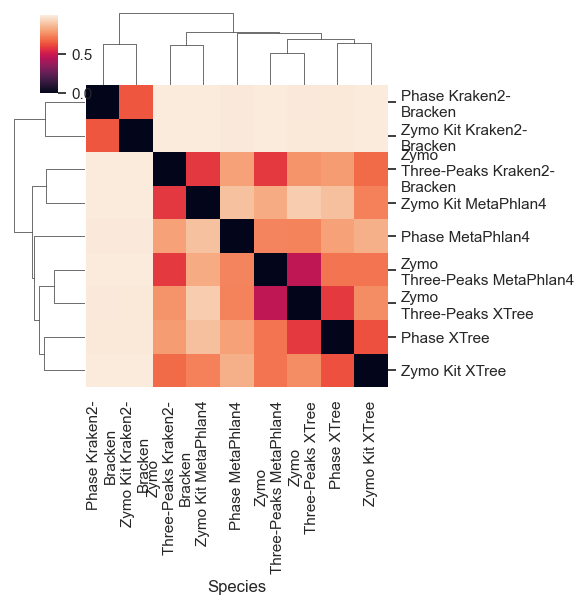

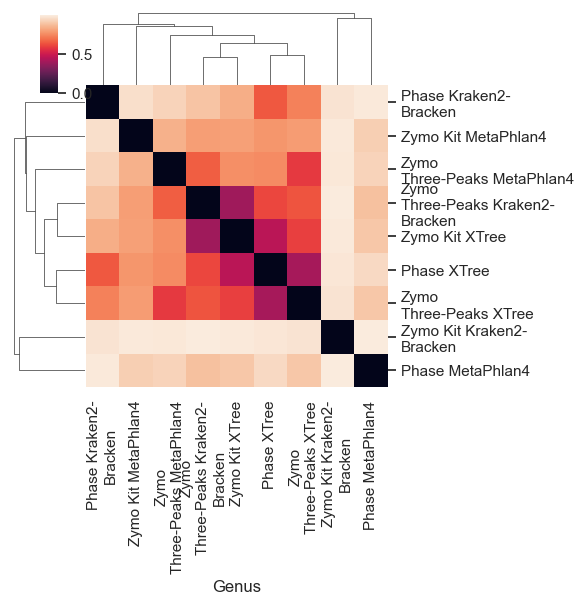

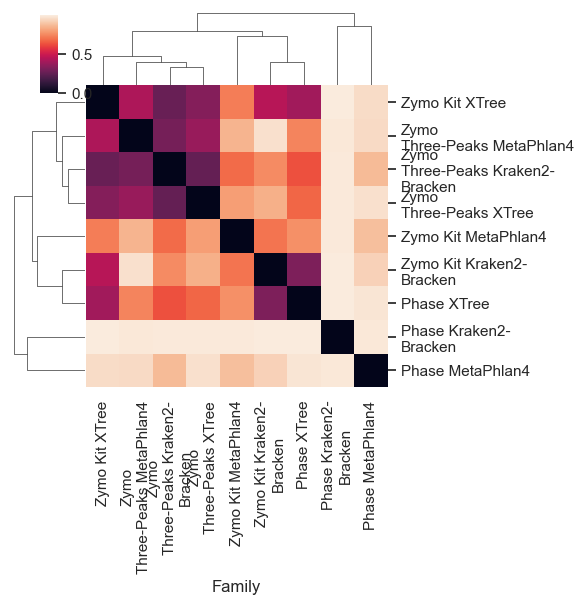

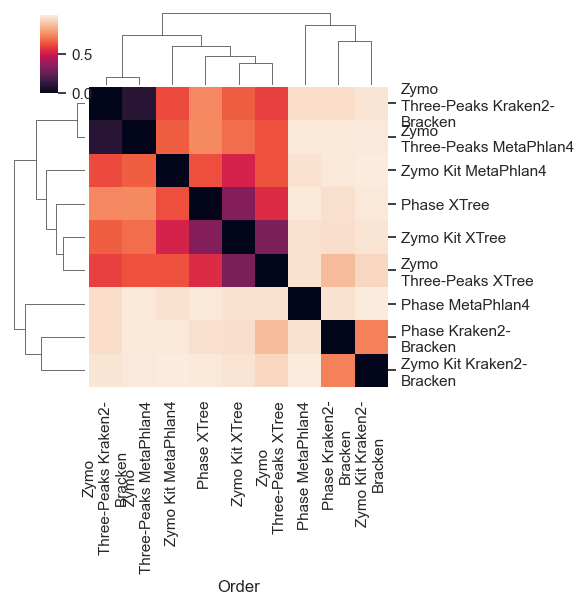

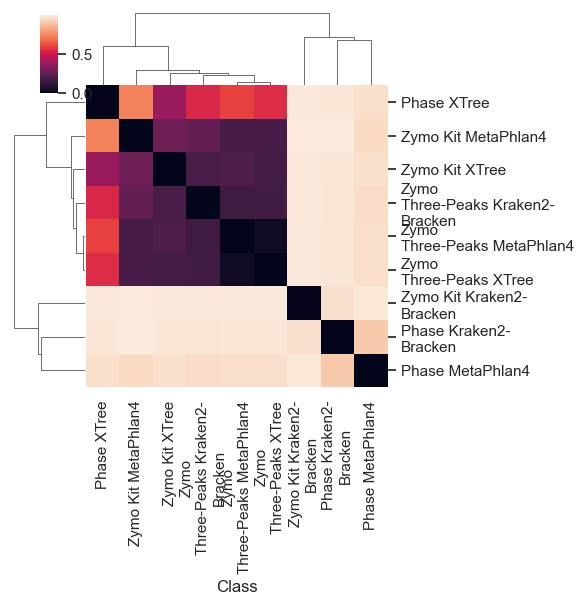

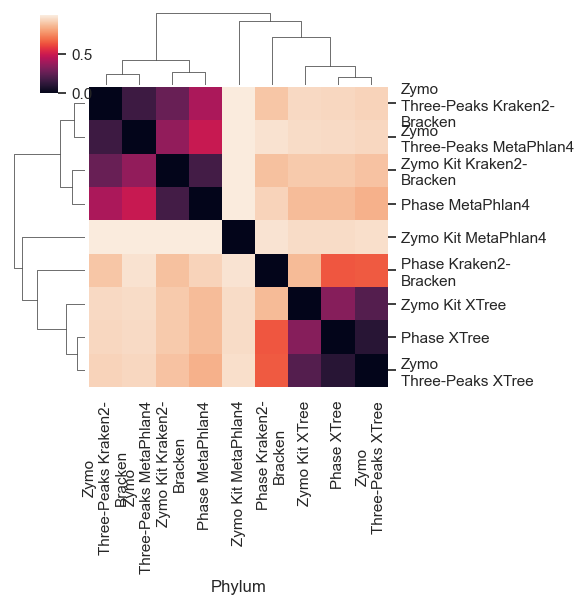

In [30]:
# Plot the Bray-Curtis dissimilarity between each combination of classification tool and  
# sample (only shared taxa)
for i, df in enumerate(rank_bcd_nona_lst):
    cluster_map(df, rank_lst[i])

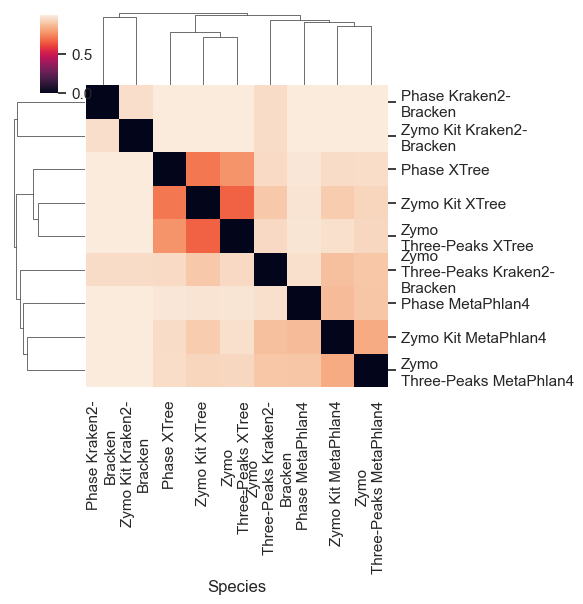

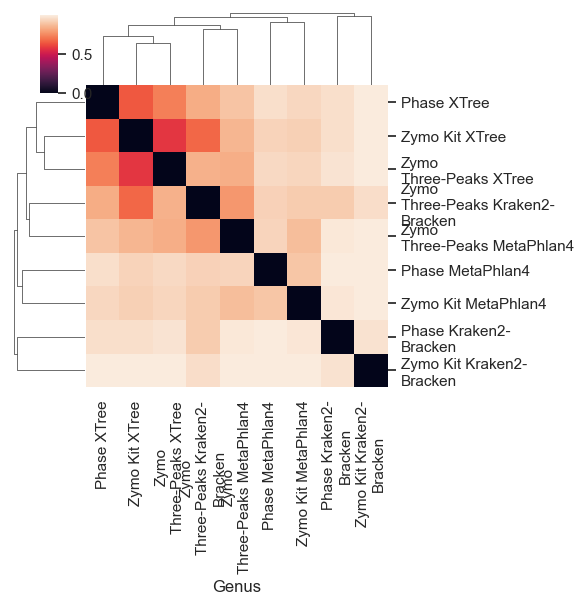

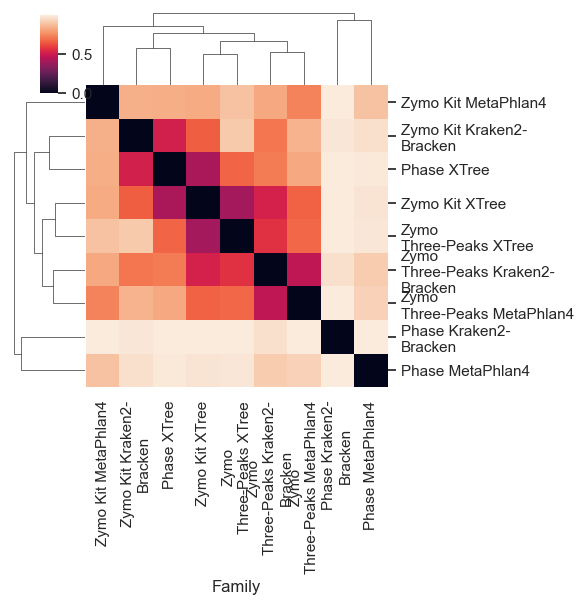

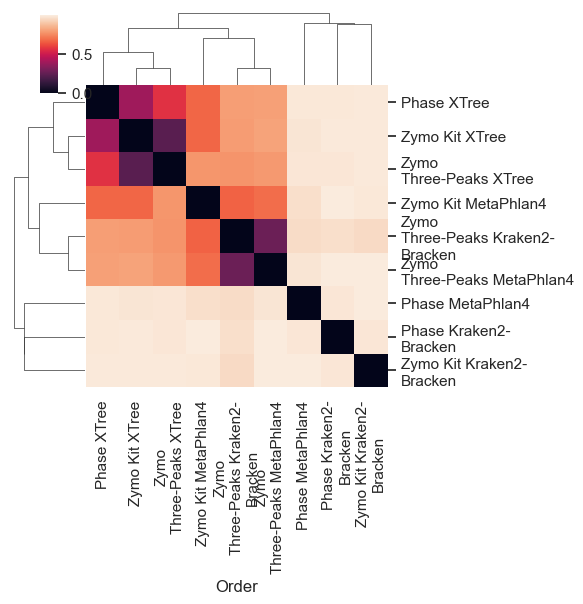

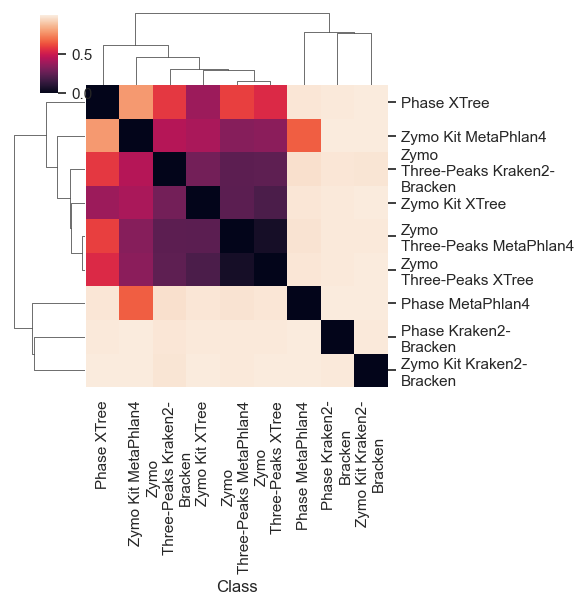

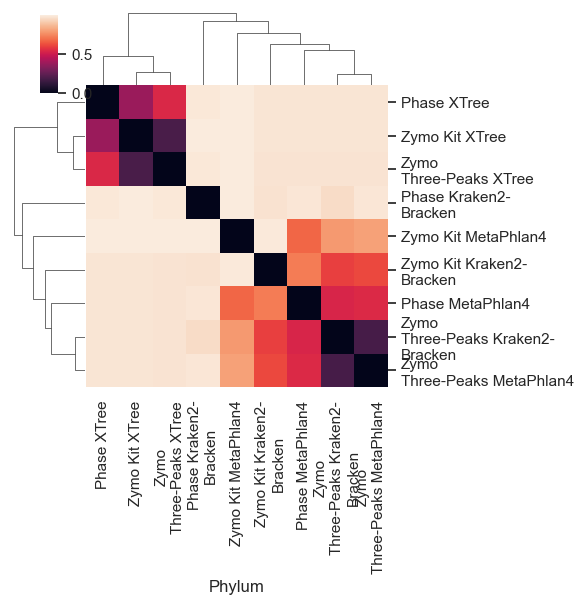

In [31]:
# Plot the Bray-Curtis dissimilarity between each combination of classification tool and 
# sample (all available taxa)
for i, df in enumerate(rank_bcd_zero_lst):
    cluster_map(df, rank_lst[i])

### Jaccard difference measuring presence-absence

In [32]:
# Make the Jaccard difference matrices based on either shared or all taxa 
rank_pa_lst = []
rank_jcd_lst = []
for i,r in enumerate(cmb_ra_lst):
    cmb_df = r.copy()
    # Make a presence-absence dataframe 
    for s in cmb_df.columns[1:]:
        cmb_df[s] = [1 if a > 0 else 0 for a in cmb_df[s]]
    rank_pa_lst.append(cmb_df)
    cleaned_df = cmb_df.drop(['clade'], axis = 1)
    t_pa_df = cleaned_df.transpose()
    jcd_df = pd.DataFrame(squareform(pdist(t_pa_df, 'jaccard')), index = t_pa_df.index, columns = t_pa_df.index)
    rank_jcd_lst.append(jcd_df)

rank_jcd_lst[0].iloc[0:3,0:3]

,Phase Kraken2-\nBracken,Zymo Kit Kraken2-\nBracken,Zymo\nThree-Peaks Kraken2-\nBracken
Phase Kraken2-\nBracken,0.000000,0.627166,0.561314
Zymo Kit Kraken2-\nBracken,0.627166,0.000000,0.446497
Zymo\nThree-Peaks Kraken2-\nBracken,0.561314,0.446497,0.000000


/Users/laurenmak/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


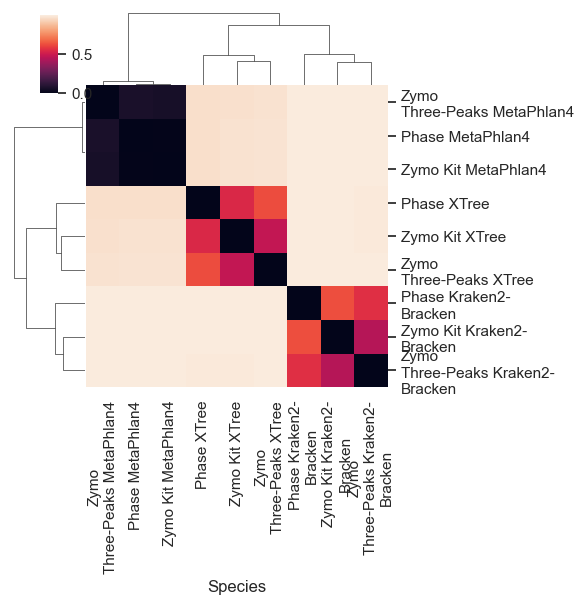

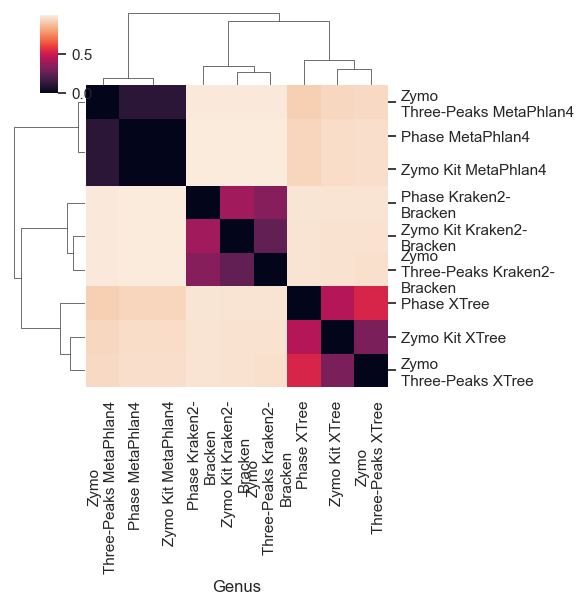

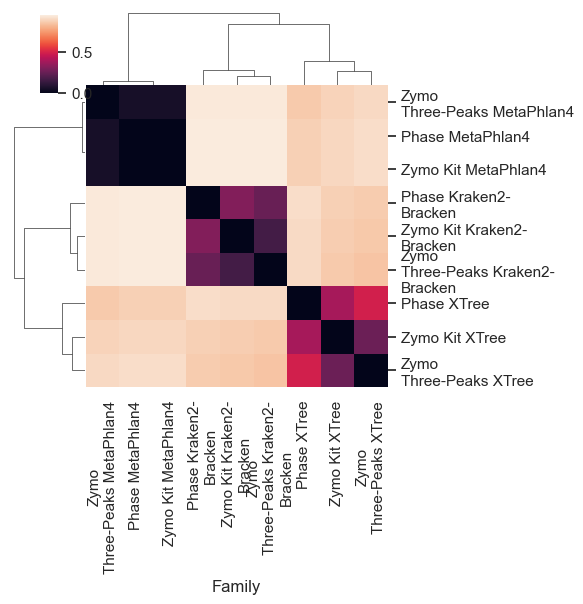

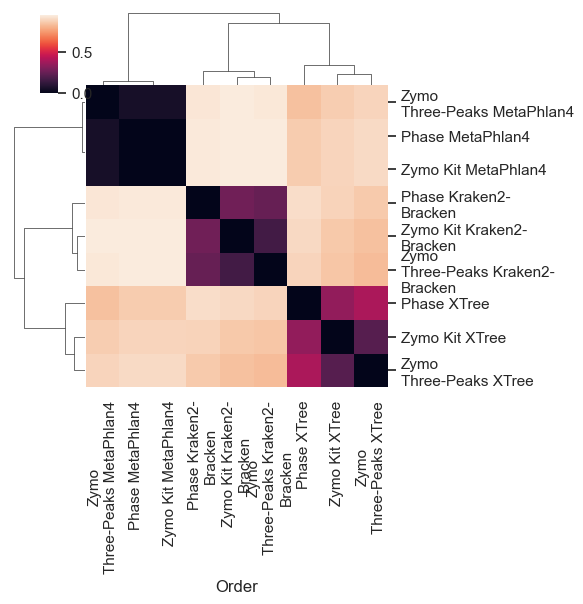

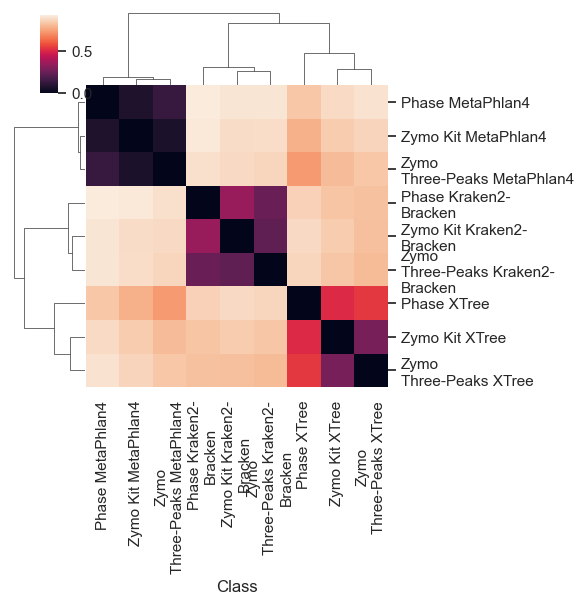

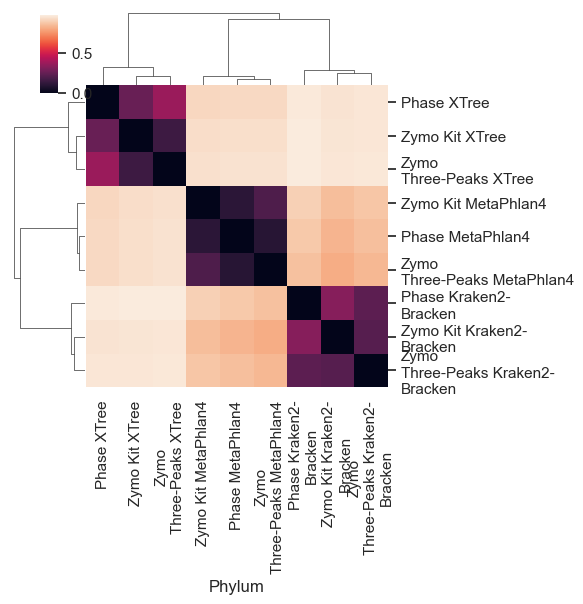

In [33]:
# Plot the Jaccard difference between each combination of classification tool and sample
for i, df in enumerate(rank_jcd_lst):
    cluster_map(df, rank_lst[i])

### Taxa sharing between classifier-sample combinations

In [34]:
# Get the phylum presence-absence dataframe
phylum_pa_df = rank_pa_lst[rank_index].copy()
phylum_pa_df.set_index('clade', inplace = True)
phylum_pa_df = phylum_pa_df.transpose()
print('{}'.format(phylum_pa_df.shape))
phylum_pa_df.iloc[:,[1,20,80]]

(9, 94)


clade,Proteobacteria,Microsporidia,Firmicutes D
Phase Kraken2-\nBracken,1,1,0
Zymo Kit Kraken2-\nBracken,1,0,0
Zymo\nThree-Peaks Kraken2-\nBracken,1,1,0
Phase MetaPhlan4,1,0,0
Zymo Kit MetaPhlan4,1,0,0
Zymo\nThree-Peaks MetaPhlan4,1,0,0
Phase XTree,1,0,0
Zymo Kit XTree,1,0,0
Zymo\nThree-Peaks XTree,1,0,1


In [35]:
def make_upset_df(raw_df):
    combo_names = list(raw_df.index)
    cmb_dct = raw_df.to_dict(orient = 'list')
    new_dct = {}
    for k,v in cmb_dct.items():
        new_dct[k] = []
        for j,pa in enumerate(v):
            if pa == 1:
                new_dct[k].append(combo_names[j])
    return new_dct

In [36]:
# Convert the presence-absence dataframes into upset plot-compatible dataframes 
# Here, I've divided the phyla up by the number of samples the phylum appeared in
phylum_cmb_lst = []
num_cmbs = phylum_pa_df.shape[0]
for i in range(1,num_cmbs + 1):
    tmp_df = phylum_pa_df.loc[:,(phylum_pa_df.sum(axis = 0) == i)]
    phylum_cmb_dct = make_upset_df(tmp_df)
    print('In {} samples: {} phyla: {}'.format(i, len(phylum_cmb_dct.keys()), list(phylum_cmb_dct.keys())))
    if phylum_cmb_dct:
        phylum_cmb_lst.append(from_contents(phylum_cmb_dct))

phylum_cmb_lst[-1]

In 1 samples: 8 phyla: ['Candidatus Lokiarchaeota', 'Negarnaviricota', 'Candidatus Saccharibacteria', 'Armatimonadota', 'Deinococcota', 'Desulfobacterota E', 'Firmicutes D', 'Omnitrophota']
In 2 samples: 24 phyla: ['Preplasmiviricota', 'Chrysiogenetes', 'Dictyoglomi', 'Cressdnaviricota', 'Thermotogae', 'Microsporidia', 'Evosea', 'Chlamydiae', 'Balneolaeota', 'Crenarchaeota', 'Coprothermobacterota', 'Apicomplexa', 'Nitrospirae', 'Fusobacteria', 'Caldiserica', 'Synergistetes', 'Fibrobacteres', 'Campylobacterota', 'Fibrobacterota', 'Halobacteriota', 'Myxococcota', 'Nitrospirota', 'Planctomycetota', 'Synergistota']
In 3 samples: 48 phyla: ['Peploviricota', 'Nucleocytoviricota', 'Ascomycota', 'Thaumarchaeota', 'Bacillariophyta', 'Deferribacteres', 'Ignavibacteriae', 'Chordata', 'candidate division Zixibacteria', 'Cossaviricota', 'Calditrichaeota', 'Candidatus Cloacimonetes', 'Uroviricota', 'Kiritimatiellaeota', 'Pisuviricota', 'Deinococcus-Thermus', 'Planctomycetes', 'Kitrinoviricota', 'Chl

id
Proteobacteria Firmicutes                                     
True           True                    Phase Kraken2-\nBracken
               True                 Zymo Kit Kraken2-\nBracken
               True        Zymo\nThree-Peaks Kraken2-\nBracken
               True                           Phase MetaPhlan4
               True                        Zymo Kit MetaPhlan4
               True               Zymo\nThree-Peaks MetaPhlan4
               True                                Phase XTree
               True                             Zymo Kit XTree
               True                    Zymo\nThree-Peaks XTree

In [37]:
# Make an upset plot for phyla that appear in a majority of the samples 
tmp_df = phylum_pa_df.loc[:,(phylum_pa_df.sum(axis = 0) > num_cmbs // 2)]
phylum_cmb_dct = make_upset_df(tmp_df)
phylum_cmb_df = from_contents(phylum_cmb_dct)
print('In a majority of samples: {} phyla: {}'.format(len(phylum_cmb_dct.keys()), list(phylum_cmb_dct.keys())))

In a majority of samples: 9 phyla: ['Proteobacteria', 'Spirochaetes', 'Bacteroidetes', 'Lentisphaerae', 'Actinobacteria', 'Cyanobacteria', 'Firmicutes', 'Tenericutes', 'Euryarchaeota']


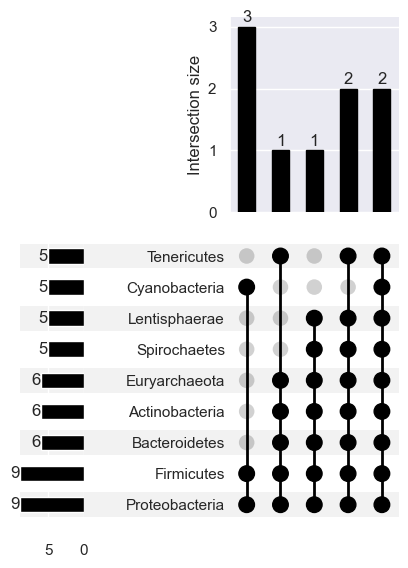

In [38]:
UpSet(phylum_cmb_df, show_counts = True)

In [39]:
# Additional dataframe exploration
# phylum_pa_df['Spirochaetes']
# phylum_cmb_df

Phase Kraken2-\nBracken                0
Zymo Kit Kraken2-\nBracken             1
Zymo\nThree-Peaks Kraken2-\nBracken    1
Phase MetaPhlan4                       1
Zymo Kit MetaPhlan4                    1
Zymo\nThree-Peaks MetaPhlan4           1
Phase XTree                            0
Zymo Kit XTree                         0
Zymo\nThree-Peaks XTree                0
Name: Spirochaetes, dtype: int64